## Load Packages

In [1]:
# Load packages
import numpy as np
import scipy
from scipy.integrate import solve_bvp
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import shift
import itertools
import sys
from tqdm import tqdm

import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax.lax import fori_loop
from functools import partial

## Construct 4D Euclidean Meshgrid

We construct a 4D mesgrid. We pick the dyon loop radius to be R=0.5 vev^(-1) as an example -- in the full code, we relax the action under a range of assumptions for the radius R.

In [2]:
R=0.5 # Dyon loop radius [1/vev]

spacing = 0.1 # Grid spacing [1/vev]
dx2 = spacing**2 # Square spacing [1/vev^2]
volume = spacing**4 # Volume per grid point [1/vev^4]
length = R+1.55  # Grid extends from -length to length in all four directions [1/vev]

grid = np.arange(-length,length+spacing,spacing) # 1D grid from which 4D grid is constructed

X,Y,Z,T = np.meshgrid(grid,grid,grid,grid,indexing='ij') # 4d grid in x,y,z,t

slice_idx = int(np.around(np.size(grid)/2.)) # index corresponding to slice through loop center

## Construct Initial Guess Field Profile from Single 't Hooft-Polyakov Solution

We now construct initial guess profile functions. We obtain these by solving the static 3D Georgi-Glashow field equations for a single monopole defect. The functions all interpolate between 0 and 1 and have no unit. We also construct a function $K(r)$, which is similar in form to the Georgi-Glashow solution. The point of the three profiles is to give us a host of good initial guessses for the 4D dyon loop profiles.

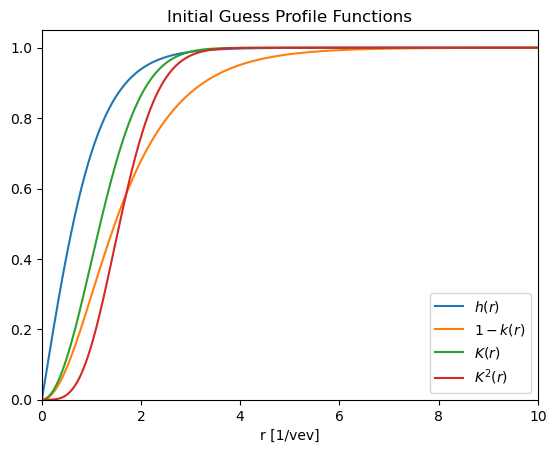

In [3]:
# Solve the Georgi-Glashow field equations that yield the Higgs and gauge field profile function 
# for a static 't Hooft-Polyakov monopole -- see e.g. Shifman for equations.

r = np.linspace(0.0001,10,10000) # Test radii [1/vev]
lamb = 1.0 # The Higgs quartic coupling [no unit]
g = 1.0 # The SU(2) gauge coupling [no unit]
vev = 1.0 # The Higgs vev [vev]

def fun(r,w):
    """
    Defines the differential equations for the h and k Higgs functions, given in Shifman.

    Arguments:
        w :  vector of the state variables:
                  w = [hp,kp,h,k]
        t :  time
        p :  vector of the parameters:
                  p = [lambda]
    """

    f = [-2/r*w[0]+2/r**2*w[3]**2*w[2]+lamb*(w[2]**2-1)*w[2],
         1/r**2*(w[3]**2-1)*w[3]+w[2]**2*w[3],
         w[0],
         w[1]]

    return np.vstack(f)

def bc(wa,wb):
    return np.array([wa[2],wa[3]-1.,wb[2]-1.,wb[3]])

# Provide some initial guesses for solving the profile equations
guess = np.ones((4,np.size(r)))

guess[0,:]=0
guess[1,:]=0

guess[2,0]=0
guess[2,-1]=1
guess[3,0]=1
guess[3,-1]=0

# Solve the profile equations
res = solve_bvp(fun, bc, r, guess,tol=1e-10)

# Define three distinct initial guess profile functions
def h_fun(r):
    return res.sol(r)[2]
def k_fun(r):
    return res.sol(r)[3]
def ken_fun(r2):
    return 1-np.exp(-r2/2)

# Plot out the profile functions
plt.plot(r,res.sol(r)[2],label='$h(r)$')
plt.plot(r,1-res.sol(r)[3],label='$1-k(r)$')
plt.plot(r,ken_fun(r**2),label='$K(r)$')
plt.plot(r,ken_fun(r**2)**2,label='$K^2(r)$')

plt.xlabel('r [1/vev]')
plt.xlim(0,10)
plt.ylim(0,1.05)
plt.legend()
plt.title('Initial Guess Profile Functions')
plt.show()

## Define coordinates and Levi-Civita Tensor

We now define the Levi-Civita tensor for arbitrary dimension, the relation between Euclidean and double polar coordinates, and the beta angle.

In [4]:
def levi_cevita_tensor(dim): # First, define levi civita tensor with (dim) number of indices
    arr=np.zeros(tuple([dim for _ in range(dim)]))
    for x in itertools.permutations(tuple(range(dim))):
        mat = np.zeros((dim, dim), dtype=np.int32)
        for i, j in zip(range(dim), x):
            mat[i, j] = -1
        arr[x]=-int(np.linalg.det(mat))
    return arr

# Define double polar coordainte system u,v,phi,tau
def phi(x,y):
    return np.arctan2(y,x) # [rad]

def tau(z,t):
    return np.arctan2(t,z) # [rad]

def u(x,y):
    return np.sqrt(x**2+y**2) # [1/vev]

def v(z,t):
    return np.sqrt(z**2+t**2) # [1/vev]

# Define beta angle
def beta(x,y,z,t):
    return np.arctan2(u(x,y),v(z,t)-R)+np.arctan2(u(x,y),v(z,t)+R) # [rad]

## Set up Initial Guess
We now construct the initial guess field profiles for $\Phi^a$ and $A_\mu^a$ to be fed into the iterative action relaxation loop. Note that we keep $\hat{\Phi}^a$ fixed but vary the Higgs field magnetiude $|\Phi|$. This amounts to fixing the non-Abelian gauge redundancy of the setup.

In [5]:
# Set up guess Higgs field configuration
Hhat=np.array([np.sin(beta(X,Y,Z,T))*np.cos(phi(X,Y)+tau(Z,T)),np.sin(beta(X,Y,Z,T))*np.sin(phi(X,Y)+tau(Z,T)),np.cos(beta(X,Y,Z,T))]) # Higgs isospin direction [no unit]
H=ken_fun(u(X,Y)**2+(v(Z,T)-R)**2)*Hhat # Full Higgs field [vev]
Hmag = np.sqrt(np.einsum('aijkl,aijkl->ijkl',H,H)) # Magnitude of Higgs field [vev]
dHhat=np.gradient(Hhat,spacing,axis={-4,-3,-2,-1}) # Derivative of Higgs isopin vector [vev^2]
ddHhat = np.einsum('bbadefg->adefg',np.gradient(dHhat,spacing,axis={-4,-3,-2,-1})) # Contracted dobule derivative of Higgs isospin vector [vev^3]

# Set up guess Abelian gauge field component
a=ken_fun(u(X,Y)**2+(v(Z,T)-R)**2)**2*2/(u(X,Y)**2+(v(Z,T)-R)**2)*np.array([-u(X,Y)*np.sin(phi(X,Y)),
u(X,Y)*np.cos(phi(X,Y)),
v(Z,T)*np.sin(tau(Z,T)),
-v(Z,T)*np.cos(tau(Z,T))])

# Set up guess  for full non-Abelian gauge field
# where the first term is the non-Abelian isospin DoF
# and the second term is the Abelian Dof.
A=-ken_fun(u(X,Y)**2+(v(Z,T)-R)**2)*(np.einsum('abc,bijkl,dcijkl->daijkl',levi_cevita_tensor(3),Hhat,dHhat))+np.einsum('aijkl,mijkl->maijkl',Hhat,a)

We now take the time to compute the field strength and action of the intial guess and plot them out.

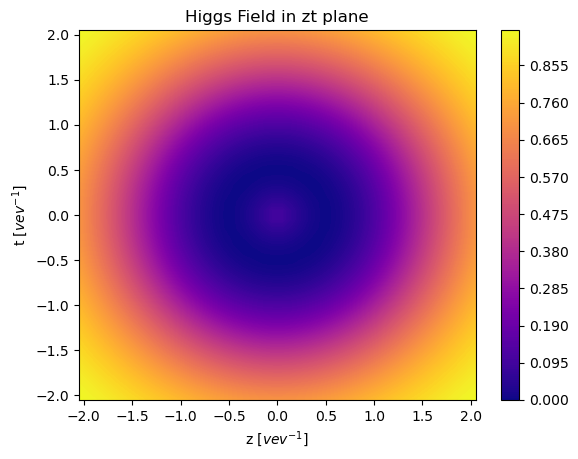

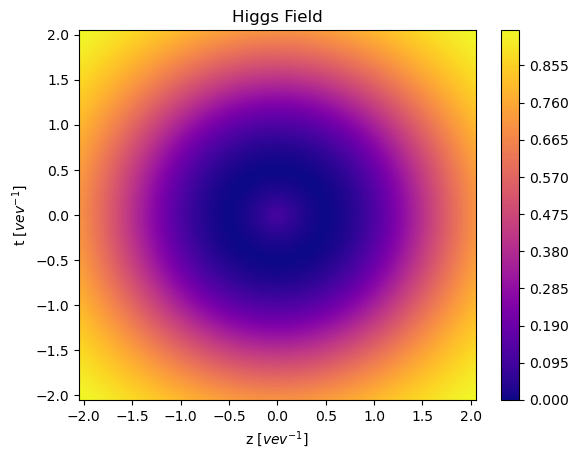

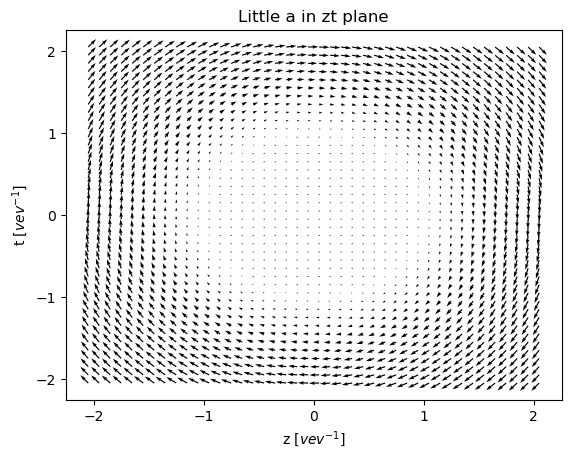

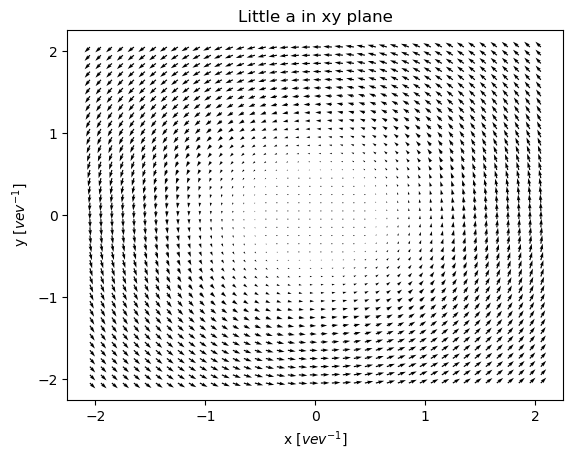

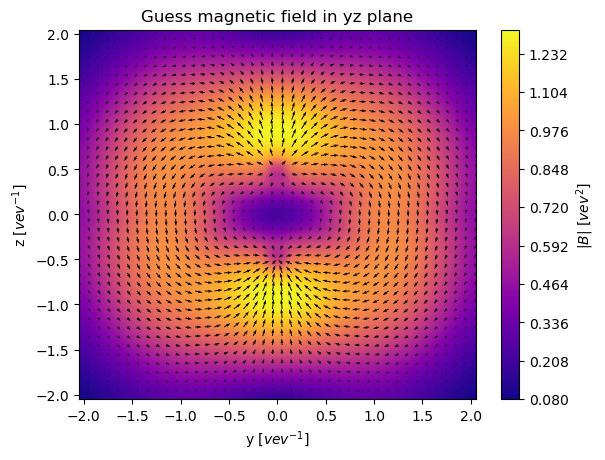

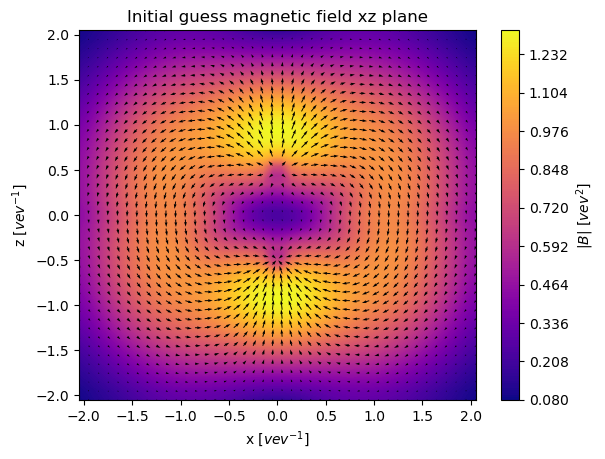

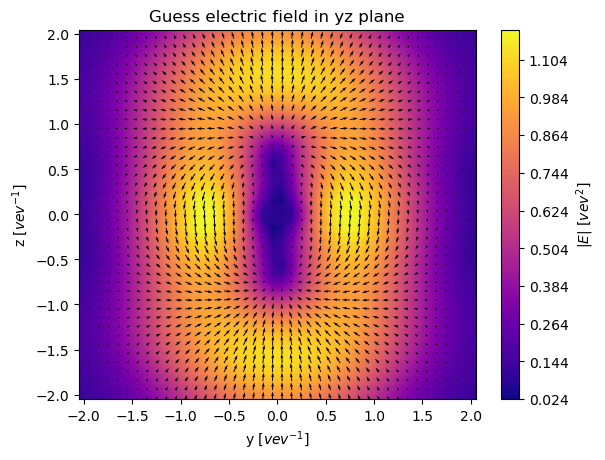

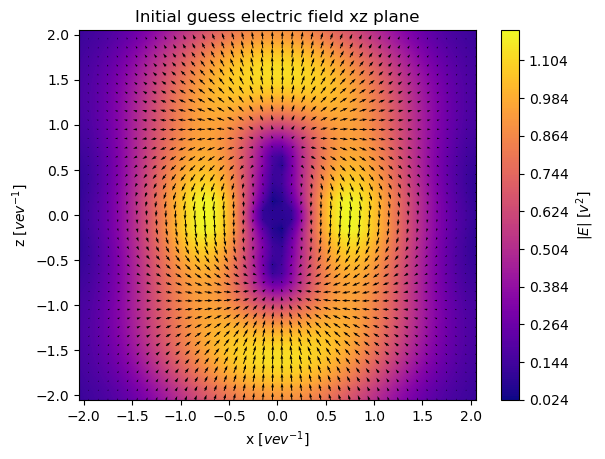

In [7]:
# Compute derivatives
dA = np.einsum('mnaijkl->mnaijkl',np.gradient(A,spacing,axis={-4,-3,-2,-1}))
dHhat=np.gradient(Hhat,spacing,axis={-4,-3,-2,-1})
dH=np.gradient(H,spacing,axis={-4,-3,-2,-1})
ddHhat = np.einsum('bbadefg->adefg',np.gradient(dHhat,spacing,axis={-4,-3,-2,-1}))

NonAbFieldStrength = dA-np.einsum('mnadefg->nmadefg',dA)+np.einsum('abc,mbefgh,ncefgh->mnaefgh',levi_cevita_tensor(3),A,A) # [vev^2]
AbFieldStrength = np.einsum('aefgh,nmaefgh->nmefgh',Hhat,NonAbFieldStrength) # [vev^2]

# Compute the various terms of the Lagrangian density
GaugeKinDensity = 1/4*np.einsum('mnaijkl,mnaijkl->ijkl',NonAbFieldStrength,NonAbFieldStrength) # [vev^4]
HiggsCov = dH + np.einsum('abc,mbijkl,cijkl->maijkl',levi_cevita_tensor(3),A,H) # [vev^4]
HiggsKinDensity = 1/2*np.einsum('maijkl,maijkl->ijkl',HiggsCov,HiggsCov) # [vev^4]
HiggsPotDensity = lamb*1/4*(np.einsum('aijkl,aijkl->ijkl',H,H)-1)**2 # [vev^4]
ActionDensity = HiggsKinDensity+HiggsPotDensity+GaugeKinDensity # Lagrangian [vev^4]
Action = np.sum(ActionDensity*volume) # [no unit]

# Plot Guess
contourf_ = plt.contourf(Z[slice_idx,slice_idx,:,:], T[slice_idx,slice_idx,:,:], np.sqrt(H[0,slice_idx,slice_idx,:,:]**2+H[1,slice_idx,slice_idx,:,:]**2+H[2,slice_idx,slice_idx,:,:]**2),cmap='plasma',levels=200)
plt.colorbar(contourf_)
plt.title('Higgs Field in zt plane')
plt.xlabel(r'z [$vev^{-1}$]')
plt.ylabel(r't [$vev^{-1}$]')
plt.show()

contourf_ = plt.contourf(Z[slice_idx,slice_idx,:,:], T[slice_idx,slice_idx,:,:], np.sqrt(H[0,slice_idx,slice_idx,:,:]**2+H[1,slice_idx,slice_idx,:,:]**2+H[2,slice_idx,slice_idx,:,:]**2),cmap='plasma',levels=200)
plt.colorbar(contourf_)
plt.xlabel(r'z [$vev^{-1}$]')
plt.ylabel(r't [$vev^{-1}$]')
plt.title('Higgs Field')
plt.show()

plt.quiver(Z[slice_idx,slice_idx,:,:],T[slice_idx,slice_idx,:,:], a[2,slice_idx,slice_idx,:,:], a[3,slice_idx,slice_idx,:,:])
plt.title('Little a in zt plane')
plt.xlabel(r'z [$vev^{-1}$]')
plt.ylabel(r't [$vev^{-1}$]')
plt.show()

plt.quiver(X[:,:,slice_idx,slice_idx],Y[:,:,slice_idx,slice_idx], a[0,:,:,slice_idx,slice_idx], a[1,:,:,slice_idx,slice_idx])
plt.title('Little a in xy plane')
plt.xlabel(r'x [$vev^{-1}$]')
plt.ylabel(r'y [$vev^{-1}$]')
plt.show()


contourf_ = plt.contourf(Y[slice_idx,:,:,slice_idx],Z[slice_idx,:,:,slice_idx], np.sqrt(AbFieldStrength[2,0,slice_idx,:,:,slice_idx]**2+AbFieldStrength[0,1,slice_idx,:,:,slice_idx]**2),cmap='plasma',levels=200)
cbar = plt.colorbar(contourf_)
cbar.set_label(r'$|B|$ [$vev^2$]')
plt.quiver(Y[slice_idx,:,:,slice_idx],Z[slice_idx,:,:,slice_idx], -AbFieldStrength[2,0,slice_idx,:,:,slice_idx], -AbFieldStrength[0,1,slice_idx,:,:,slice_idx])
plt.title('Guess magnetic field in yz plane')
plt.xlabel(r'y [$vev^{-1}$]')
plt.ylabel(r'z [$vev^{-1}$]')
plt.show()

contourf_=plt.contourf(X[:,slice_idx,:,slice_idx],Z[:,slice_idx,:,slice_idx], np.sqrt(AbFieldStrength[1,2,:,slice_idx,:,slice_idx]**2+ AbFieldStrength[0,1,:,slice_idx,:,slice_idx]**2),cmap='plasma',levels=200)
plt.quiver(X[:,slice_idx,:,slice_idx],Z[:,slice_idx,:,slice_idx], -AbFieldStrength[1,2,:,slice_idx,:,slice_idx], -AbFieldStrength[0,1,:,slice_idx,:,slice_idx])
cbar = plt.colorbar(contourf_)
cbar.set_label(r'$|B|$ [$vev^2$]')
plt.title('Initial guess magnetic field xz plane')
plt.xlabel(r'x [$vev^{-1}$]')
plt.ylabel(r'z [$vev^{-1}$]')
plt.show()

contourf_ = plt.contourf(Y[slice_idx,:,:,slice_idx],Z[slice_idx,:,:,slice_idx], np.sqrt(AbFieldStrength[3,1,slice_idx,:,:,slice_idx]**2+AbFieldStrength[3,2,slice_idx,:,:,slice_idx]**2),cmap='plasma',levels=200)
plt.quiver(Y[slice_idx,:,:,slice_idx],Z[slice_idx,:,:,slice_idx], AbFieldStrength[3,1,slice_idx,:,:,slice_idx], AbFieldStrength[3,2,slice_idx,:,:,slice_idx])
cbar = plt.colorbar(contourf_)
cbar.set_label(r'$|E|$ [$vev^2$]')
plt.title('Guess electric field in yz plane')
plt.xlabel(r'y [$vev^{-1}$]')
plt.ylabel(r'z [$vev^{-1}$]')
plt.show()

contourf_ = plt.contourf(X[:,slice_idx,:,slice_idx],Z[:,slice_idx,:,slice_idx], np.sqrt(AbFieldStrength[3,0,:,slice_idx,:,slice_idx]**2+ AbFieldStrength[3,2,:,slice_idx,:,slice_idx]**2),cmap='plasma',levels=200)
plt.quiver(X[:,slice_idx,:,slice_idx],Z[:,slice_idx,:,slice_idx], AbFieldStrength[3,0,:,slice_idx,:,slice_idx], AbFieldStrength[3,2,:,slice_idx,:,slice_idx])
cbar = plt.colorbar(contourf_)
cbar.set_label(r'$|E|$ [$v^2$]')
plt.title('Initial guess electric field xz plane')
plt.xlabel(r'x [$vev^{-1}$]')
plt.ylabel(r'z [$vev^{-1}$]')
plt.show()

# Set up relaxation

## JAX relaxation

In [ ]:
A_guess = jnp.array(A) 
u_guess = jnp.array(Hmag) 

Hhat = jnp.asarray(Hhat)
dHhat = jnp.asarray(dHhat)
ddHhat = jnp.asarray(ddHhat)

@jit
def relaxation_step_jax(u,A,lambd,spacing,alpha):
    dx2 = spacing**2
    dA_mu = jnp.asarray(jnp.gradient(A,spacing,axis=(-4,-3,-2,-1)))
    ddA_mu = jnp.asarray(jnp.gradient(dA_mu,spacing,axis=(-4,-3,-2,-1)))
    # Compute sum of Higgs neighboring points
    u_neighbors = (
        (jnp.roll(u, 1, axis=-4) + jnp.roll(u, -1, axis=-4)) 
        + (jnp.roll(u, 1, axis=-3) + jnp.roll(u, -1, axis=-3)) 
        + (jnp.roll(u, 1, axis=-2) + jnp.roll(u, -1, axis=-2)) 
        + (jnp.roll(u, 1, axis=-1) + jnp.roll(u, -1, axis=-1))
    )
    # Compute gradient of higgs magnitude
    u_grad = jnp.asarray(jnp.gradient(u,spacing,axis=(-4,-3,-2,-1)))
    # Compute derivative term
    der_term = jnp.einsum('ijkl,aijkl->aijkl',u,ddHhat) + 2*jnp.einsum('mijkl,maijkl->aijkl',u_grad,dHhat)
    linear_term = lambd*jnp.einsum('aijkl,ijkl->aijkl',Hhat,u)*vev**2
    gauge_term = (
        2*g*jnp.einsum('abc,cijkl,mbijkl,mijkl->aijkl',levi_cevita_tensor(3),Hhat,A,u_grad) 
        + u*2*g*jnp.einsum('abc,mbijkl,mcijkl->aijkl',levi_cevita_tensor(3),A,dHhat)
        + u*g*jnp.einsum('abc,mmbijkl,cijkl->aijkl',levi_cevita_tensor(3),dA_mu,Hhat) 
        + u*g**2*jnp.einsum('abc,cde,eijkl,mbijkl,mdijkl->aijkl',levi_cevita_tensor(3),levi_cevita_tensor(3),Hhat,A,A)
    )
    rhs = lambd * jnp.einsum('aijkl,ijkl->aijkl',Hhat,u**3)
    # Compute the first term in the alpha*(...) part of the equation
    u_coeff = (1/8)*(u_neighbors+dx2*(jnp.einsum('aijkl,aijkl->ijkl',Hhat,der_term+gauge_term+linear_term-rhs)))
    # Define the new Higgs field
    u_new = u + alpha * (u_coeff-u)

    ### EoM for A ###
    # Compute sum of gauge field neighboring points
    A_neighbors = (
        (jnp.roll(A, 1, axis=-4) + jnp.roll(A, -1, axis=-4)) 
        + (jnp.roll(A, 1, axis=-3) + jnp.roll(A, -1, axis=-3)) 
        + (jnp.roll(A, 1, axis=-2) + jnp.roll(A, -1, axis=-2)) 
        + (jnp.roll(A, 1, axis=-1) + jnp.roll(A, -1, axis=-1))
    )
    ### Terms below enter into g(...) in the notation of this notebook.
    gauge_term_a = (
        g*jnp.einsum('abc,mbijkl,nncijkl->maijkl',levi_cevita_tensor(3),A,dA_mu)
        + g*jnp.einsum('abc,nbijkl,mncijkl->maijkl',levi_cevita_tensor(3),A,dA_mu)
        + g**2*jnp.einsum('maijkl,nbijkl,nbijkl->maijkl',A,A,A) 
        - g**2*jnp.einsum('naijkl,nbijkl,mbijkl->maijkl',A,A,A) 
        - 2*g*jnp.einsum('abc,nbijkl,nmcijkl->maijkl',levi_cevita_tensor(3),A,dA_mu)
    )
    # Compute the mixed gradient term
    der_term_gauge = jnp.einsum('nmnaijkl->maijkl',ddA_mu)
    # Compute the right-hand side (RHS) of the equation
    rhs_gauge = (
        -g * jnp.einsum('ijkl,abc,bijkl,mcijkl->maijkl',u**2, levi_cevita_tensor(3), Hhat, dHhat) 
        - g**2 * jnp.einsum('maijkl,ijkl->maijkl',A,u**2) 
        + g**2 * jnp.einsum('ijkl,aijkl,mbijkl,bijkl->maijkl',u**2,Hhat,A,Hhat)
    )
    # Fix Lorenz gauge (generally not enforced to minimize distance to field equation solution, so commented out)
    #gauge_fixing_term = jnp.einsum('mijkl,aijkl->maijkl',jnp.einsum('maijkl,aijkl->mijkl',A,Hhat),Hhat)
    # Compute the first term in the alpha*(...) part of the equation
    A_coeff = (1/8)*(A_neighbors-dx2*gauge_term_a-dx2*der_term_gauge+dx2*rhs_gauge)
    # Flipped sign due to appearance of minus sign in front of Laplacian in EoM 
    A_new = A + alpha * (A_coeff-A)

    # Update the fields
    u_out = u.at[1:-1, 1:-1, 1:-1, 1:-1].set(u_new[1:-1, 1:-1, 1:-1, 1:-1])
    A_out = A.at[:, :, 1:-1, 1:-1, 1:-1, 1:-1].set(A_new[:, :, 1:-1, 1:-1, 1:-1, 1:-1])

    return u_out, A_out

In [ ]:
relaxation_step_jax(u_guess,A_guess,lamb,spacing,alpha=0.1);

In [ ]:
relaxation_step_jax(u_guess,A_guess,lamb,spacing,alpha=0.1);

In [ ]:
%timeit -n 5 -r 5 relaxation_step_jax(u_guess,A_guess,lamb,spacing,alpha=0.1)

In [ ]:
def relaxation_loop_jax(u, A, lambd, spacing, alpha, max_iterations):
    '''
    Input:
            A_guess: initial guess SU(2) gauge field [vev]
            u_guess: initial guess Higgs magnitude [vev]
            lambd: Higgs quartic coupling
            dx2: Square of pixel spacing [1/vev^2]
            tol: the maximally tolarated residual in the field equations for convergence
            max_iterations: Terminate after this number of iterations if no convergence is reached
            alpha: updates the field configurations as (new_field) = (old_field) + alpha*(equation_soln-old_field) 

    Output:
            u: Output Higgs field, (grid_pts,,grid_pts,grid_pts,grid_pts) [vev]
            A: Output SU(2) gauge field, (3,4,grid_pts,grid_pts,grid_pts,grid_pts) array [vev]

    '''
    def body_fun(iter_idx, state):
        u, A, max_change = state  # Include additional state for tracking
        u_new, A_new = relaxation_step_jax(u, A, lambd, spacing, alpha)
        
        # Compute max change for convergence tracking
        max_change_new = jnp.maximum(
            jnp.max(jnp.abs(u_new - u)),
            jnp.max(jnp.abs(A_new - A))
        )
        return u_new, A_new, max_change_new

    # Initial state: fields and max_change
    init_state = (u, A, 0.0)
    
    # Run the loop
    u_final, A_final, max_change_final = jax.lax.fori_loop(0, max_iterations, body_fun, init_state)
    
    return u_final, A_final, max_change_final

## Numpy relaxation

In [ ]:
A_guess = np.array(A).copy()
u_guess = np.array(Hmag).copy()

Hhat = np.asarray(Hhat).copy()
dHhat = np.asarray(dHhat).copy()
ddHhat = np.asarray(ddHhat).copy()

def relaxation_step(u,A,lambd,spacing,alpha):
    dx2 = spacing**2
    dA_mu = np.asarray(np.gradient(A,spacing,axis=(-4,-3,-2,-1)))
    ddA_mu = np.asarray(np.gradient(dA_mu,spacing,axis=(-4,-3,-2,-1)))
    # Compute sum of Higgs neighboring points
    u_neighbors = (
        (np.roll(u, 1, axis=-4) + np.roll(u, -1, axis=-4)) 
        + (np.roll(u, 1, axis=-3) + np.roll(u, -1, axis=-3)) 
        + (np.roll(u, 1, axis=-2) + np.roll(u, -1, axis=-2)) 
        + (np.roll(u, 1, axis=-1) + np.roll(u, -1, axis=-1))
    )
    # Compute gradient of higgs magnitude
    u_grad = np.asarray(np.gradient(u,spacing,axis=(-4,-3,-2,-1)))
    # Compute derivative term
    der_term = np.einsum('ijkl,aijkl->aijkl',u,ddHhat) + 2*np.einsum('mijkl,maijkl->aijkl',u_grad,dHhat)
    linear_term = lambd*np.einsum('aijkl,ijkl->aijkl',Hhat,u)*vev**2
    gauge_term = (
        2*g*np.einsum('abc,cijkl,mbijkl,mijkl->aijkl',levi_cevita_tensor(3),Hhat,A,u_grad) 
        + u*2*g*np.einsum('abc,mbijkl,mcijkl->aijkl',levi_cevita_tensor(3),A,dHhat)
        + u*g*np.einsum('abc,mmbijkl,cijkl->aijkl',levi_cevita_tensor(3),dA_mu,Hhat)
        + u*g**2*np.einsum('abc,cde,eijkl,mbijkl,mdijkl->aijkl',levi_cevita_tensor(3),levi_cevita_tensor(3),Hhat,A,A)
    )
    rhs = lambd * np.einsum('aijkl,ijkl->aijkl',Hhat,u**3)
    # Compute the first term in the alpha*(...) part of the equation
    u_coeff = (1/8)*(u_neighbors+dx2*(np.einsum('aijkl,aijkl->ijkl',Hhat,der_term+gauge_term+linear_term-rhs)))
    # Define the new Higgs field
    u_new = u + alpha * (u_coeff-u)

    ### EoM for A ###
    # Compute sum of gauge field neighboring points
    A_neighbors = (
        (np.roll(A, 1, axis=-4) + np.roll(A, -1, axis=-4)) 
        + (np.roll(A, 1, axis=-3) + np.roll(A, -1, axis=-3)) 
        + (np.roll(A, 1, axis=-2) + np.roll(A, -1, axis=-2)) 
        + (np.roll(A, 1, axis=-1) + np.roll(A, -1, axis=-1))
    )
    ### Terms below enter into g(...) in the notation of this notebook.
    gauge_term_a = (
        g*np.einsum('abc,mbijkl,nncijkl->maijkl',levi_cevita_tensor(3),A,dA_mu)
        + g*np.einsum('abc,nbijkl,mncijkl->maijkl',levi_cevita_tensor(3),A,dA_mu)
        + g**2*np.einsum('maijkl,nbijkl,nbijkl->maijkl',A,A,A) 
        - g**2*np.einsum('naijkl,nbijkl,mbijkl->maijkl',A,A,A) 
        - 2*g*np.einsum('abc,nbijkl,nmcijkl->maijkl',levi_cevita_tensor(3),A,dA_mu))
    # Compute the mixed gradient term
    der_term_gauge = np.einsum('nmnaijkl->maijkl',ddA_mu)
    # Compute the right-hand side (RHS) of the equation
    rhs_gauge = (
        -g * np.einsum('ijkl,abc,bijkl,mcijkl->maijkl',u**2, levi_cevita_tensor(3), Hhat, dHhat) 
        - g**2 * np.einsum('maijkl,ijkl->maijkl',A,u**2) 
        + g**2 * np.einsum('ijkl,aijkl,mbijkl,bijkl->maijkl',u**2,Hhat,A,Hhat)
        )
    # Fix Lorenz gauge (generally not enforced to minimize distance to field equation solution, so commented out)
    #gauge_fixing_term = np.einsum('mijkl,aijkl->maijkl',np.einsum('maijkl,aijkl->mijkl',A,Hhat),Hhat)
    # Compute the first term in the alpha*(...) part of the equation
    A_coeff = (1/8)*(A_neighbors-dx2*gauge_term_a-dx2*der_term_gauge+dx2*rhs_gauge)
    # Flipped sign due to appearance of minus sign in front of Laplacian in EoM 
    A_new = A + alpha * (A_coeff-A)

    # Update the fields
    # u[1:-1,1:-1,1:-1,1:-1] = u_new[1:-1,1:-1,1:-1,1:-1]
    # A[:,:,1:-1,1:-1,1:-1,1:-1] = A_new[:,:,1:-1,1:-1,1:-1,1:-1]

    return u_new, A_new

In [ ]:
u_new, A_new = relaxation_step(u_guess,A_guess,lamb,spacing,alpha=0.1)

In [ ]:
np.max(u_new - u_guess)

In [ ]:
def relaxation_loop(u, A, lambd, spacing, alpha, max_iterations):
    '''
    Input:
            A_guess: initial guess SU(2) gauge field [vev]
            u_guess: initial guess Higgs magnitude [vev]
            lambd: Higgs quartic coupling
            dx2: Square of pixel spacing [1/vev^2]
            tol: the maximally tolarated residual in the field equations for convergence
            max_iterations: Terminate after this number of iterations if no convergence is reached
            alpha: updates the field configurations as (new_field) = (old_field) + alpha*(equation_soln-old_field) 

    Output:
            u: Output Higgs field, (grid_pts,,grid_pts,grid_pts,grid_pts) [vev]
            A: Output SU(2) gauge field, (3,4,grid_pts,grid_pts,grid_pts,grid_pts) array [vev]

    '''
    def body_fun(state):
        u, A, max_change = state  # Include additional state for tracking
        u_new, A_new = relaxation_step(u, A, lambd, spacing, alpha)
        
        # Compute max change for convergence tracking
        max_change_new = jnp.maximum(
            jnp.max(jnp.abs(u_new - u)),
            jnp.max(jnp.abs(A_new - A))
        )
        return u_new, A_new, max_change_new

    # Initial state: fields and max_change
    state = (u, A, 0.0)
    
    # Run the loop
    for i in range(max_iterations):
        state_new = body_fun(state)
        state = (state_new[0],state_new[1],state_new[2])

    u_final, A_final, max_change_final = state
    
    return u_final, A_final, max_change_final

# Run relaxation

## Numpy relaxation

In [ ]:
alpha = 0.1  # Mixing coefficient
max_iterations = int(100000)  # Maximum number of iterations

# Run the relaxation loop
u_final, A_final, max_change_final = relaxation_loop(u_guess, A_guess, lamb, spacing, alpha, max_iterations)

In [ ]:
print('max_change_final = %.3g' % max_change_final)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

im0 = ax[0].pcolormesh(Z[slice_idx,slice_idx,:,:], T[slice_idx,slice_idx,:,:],
                       Hmag[slice_idx,slice_idx,:,:],
                       cmap='inferno',shading='nearest')
im1 = ax[1].pcolormesh(Z[slice_idx,slice_idx,:,:], T[slice_idx,slice_idx,:,:],
                       u_final[slice_idx,slice_idx,:,:],
                       cmap='inferno',shading='nearest')
ax[0].set_title(r'Ansatz Higgs Field in $zt$ plane')
ax[1].set_title(r'Relaxed Higgs Field in $zt$ plane')
# cbar0 = fig.colorbar(im0, ax=ax[0], orientation='vertical')
# cbar0.set_label('Higgs Field Magnitude')
# cbar1 = fig.colorbar(im1, ax=ax[1], orientation='vertical')
# cbar1.set_label('Relaxed Higgs Field Magnitude')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im0, cax=cax, label=r'$|\Phi|$')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im1, cax=cax, label=r'$|\Phi|$')
for i in range(2):
    ax[i].set_xlabel(r'z [$\Phi_0^{-1}$]')
    ax[i].set_ylabel(r't [$\Phi_0^{-1}$]')
    ax[i].set_aspect('equal')
plt.tight_layout()

## JAX relaxation

In [ ]:
alpha = 0.1  # Mixing coefficient
max_iterations = int(100000)  # Maximum number of iterations

# Run the relaxation loop
u_final, A_final, max_change_final = relaxation_loop_jax(u_guess, A_guess, lamb, spacing, alpha, max_iterations)


In [ ]:
# actual loop calculation will only be performed at this step
u_plot = np.asarray(u_final)
A_plot = np.asarray(A_final)
max_change_plot = np.asarray(max_change_final)
print('max_change_plot = %.2g' % max_change_plot)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))

im0 = ax[0].pcolormesh(Z[slice_idx,slice_idx,:,:], T[slice_idx,slice_idx,:,:],
                       Hmag[slice_idx,slice_idx,:,:],
                       cmap='inferno',shading='nearest')
im1 = ax[1].pcolormesh(Z[slice_idx,slice_idx,:,:], T[slice_idx,slice_idx,:,:],
                       u_plot[slice_idx,slice_idx,:,:],
                       cmap='inferno',shading='nearest')
ax[0].set_title(r'Ansatz Higgs Field in $zt$ plane')
ax[1].set_title(r'Relaxed Higgs Field in $zt$ plane')
# cbar0 = fig.colorbar(im0, ax=ax[0], orientation='vertical')
# cbar0.set_label('Higgs Field Magnitude')
# cbar1 = fig.colorbar(im1, ax=ax[1], orientation='vertical')
# cbar1.set_label('Relaxed Higgs Field Magnitude')

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im0, cax=cax, label=r'$|\Phi|$')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im1, cax=cax, label=r'$|\Phi|$')
for i in range(2):
    ax[i].set_xlabel(r'z [$\Phi_0^{-1}$]')
    ax[i].set_ylabel(r't [$\Phi_0^{-1}$]')
    ax[i].set_aspect('equal')
plt.tight_layout()